# SETUP

In [1]:
!cp '/content/drive/MyDrive/Colab Notebooks/Wastewater Treatment/train_processed.csv' '.'
!cp '/content/drive/MyDrive/Colab Notebooks/Wastewater Treatment/test_processed.csv' '.'

In [2]:
import math
from math import sqrt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import numpy as np

# RevIN

In [3]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

# PatchTST Layer

In [4]:
__all__ = ['Transpose', 'get_activation_fn', 'moving_avg', 'series_decomp', 'PositionalEncoding', 'SinCosPosEncoding', 'Coord2dPosEncoding', 'Coord1dPosEncoding', 'positional_encoding']

import torch
from torch import nn
import math

class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False):
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')


# decomposition

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean



# pos_encoding

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, d_model):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

# Model

In [5]:
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.configs = configs
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.c_in = configs.enc_in
        self.decomposition = configs.decomposition
        kernel_size = configs.kernel_size
        self.decomp_module = series_decomp(kernel_size)
        self.revin_layer = RevIN(configs.enc_in, affine=configs.affine, subtract_last=configs.subtract_last)
        self.trend_revin_layer = RevIN(configs.enc_in, affine=configs.affine, subtract_last=configs.subtract_last)
        self.period_list = configs.period_list
        self.emb = configs.emb # is important for Transformer Attention

        # model
        self.model = FRNet_backone(self.c_in, self.seq_len, self.pred_len, self.emb, configs.revin, configs.dropout, configs.e_layers, configs.pred_head_type, configs.aggregation_type, configs.channel_attention, configs.global_freq_pred, self.period_list)
        if self.decomposition:
            self.model_trend = FRNet_trend_backone(self.c_in, self.seq_len, self.pred_len, self.emb, configs.revin, configs.dropout, configs.e_layers, configs.pred_head_type, configs.aggregation_type, configs.channel_attention, configs.global_freq_pred, configs.patch_len, configs.stride)
        self.linear_projection =  nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.pred_len, self.pred_len)
        )

    def forward(self, x):
        if self.decomposition:
            res_init, trend_init = self.decomp_module(x)
            res_init, trend_init = res_init.permute(0,2,1), trend_init.permute(0,2,1)  # x: [Batch, Channel, Input length]
            res = self.model(res_init)
            trend = self.model_trend(trend_init)
            x = res + trend
            x = x.permute(0,2,1)    # x: [Batch, Input length, Channel]
        else:
            x = x.permute(0,2,1)    # x: [Batch, Channel, Input length]
            x = self.model(x)
            x = x.permute(0,2,1)    # x: [Batch, Input length, Channel]

        return x


class FRNet_backone(nn.Module):
    def __init__(self, c_in, seq_len, pred_len, emb, revin, dropout, e_layers, pred_head_type, aggregation_type, channel_attention, global_freq_pred, period_list):
        super().__init__()
        self.period_list = period_list
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.channels = c_in
        self.revin = revin
        self.channel_attention = channel_attention
        #Complex Rotate
        self.FRBackboneList = nn.ModuleList()
        # #FITS
        self.global_freq_pred = global_freq_pred
        if self.global_freq_pred:
            self.dominance_freq=int(self.seq_len // self.period_list[0] + 1) * 2 + 10
            self.length_ratio = (self.pred_len)/self.seq_len
            self.freq_Linear = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat)
            self.fit_channelfuse = ChannelAttentionLayer(FullAttention(attention_dropout=0.1, output_attention=False), seq_len, 8)
        if self.revin:
            self.revin_layer = RevIN(c_in, affine=True, subtract_last=False)
        for k in range(len(self.period_list)):
            self.FRBackboneList.append(FRBackbone(self.period_list[k], c_in, seq_len, pred_len, emb, dropout, e_layers, pred_head_type, channel_attention))
        self.aggregation_type = aggregation_type
        if aggregation_type == 'linear':
            if global_freq_pred:
                self.fuse_linear = nn.Linear(pred_len*(1 + len(self.period_list)), pred_len)
            else:
                self.fuse_linear = nn.Linear(pred_len*len(self.period_list), pred_len)

    def forward(self, x):
        # norm
        if self.revin:
            x = x.permute(0,2,1)
            x = self.revin_layer(x, 'norm')
            x = x.permute(0,2,1)
        res = [] #存放不同topk周期
        if self.global_freq_pred:
            # if self.channel_attention:
            #     x = self.fit_channelfuse(x, x, x)[0]
            low_specx = torch.fft.rfft(x, dim=-1)
            low_specx[:,:,self.dominance_freq:]=0 # LPF截断
            low_specx = low_specx[:,:,0:self.dominance_freq] # LPF
            # print(low_specx.permute(0,2,1).shape, self.freq_Linear)
            low_specxy_ = self.freq_Linear(low_specx)
            low_specxy = torch.zeros([low_specxy_.size(0), low_specxy_.size(1), int((self.pred_len)/2+1)],dtype=low_specxy_.dtype).to(low_specxy_.device)

            low_specxy[:,:,0:low_specxy_.size(-1)]=low_specxy_
            low_xy=torch.fft.irfft(low_specxy, dim=-1)
            # low_xy=low_xy * self.length_ratio # compemsate the length change
            res.append(low_xy)

        for k in range(len(self.period_list)):
            length = self.seq_len
            period_i = self.period_list[k]
            # reshape [b, l , c]
            if length % period_i != 0:
                new_length = (length // period_i) * period_i
                x_k = x[:, :, -new_length:]
            else:
                new_length = length
                x_k = x
            x_k = x_k.unfold(dimension=-1, size=period_i, step=period_i)    # [b, c, l] -> [b,c,n,p] # stride = period_i
            # model
            pred_k = self.FRBackboneList[k](x_k)                                                                # z: [bs x nvars x d_model x patch_num]
            res.append(pred_k)
        if self.aggregation_type == 'linear':
            concatenated_res = torch.cat(res, dim=-1)
            res = self.fuse_linear(concatenated_res)
        elif self.aggregation_type == 'avg':
            concatenated_res = torch.stack(res, dim=-1)
            num = len(self.period_list) + 1 if self.global_freq_pred else len(self.period_list)
            res = torch.sum(concatenated_res * (1 / num), -1)
        if self.revin:
            res = res.permute(0,2,1)
            res = self.revin_layer(res, 'denorm')
            res = res.permute(0,2,1)
        return res

class FRNet_trend_backone(nn.Module):
    def __init__(self, c_in, seq_len, pred_len, emb, revin, dropout, e_layers, pred_head_type, aggregation_type, channel_attention, global_freq_pred, patch_len, stride):
        super().__init__()
        # self.patch_len = patch_len
        # self.stride = stride
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.channels = c_in
        self.revin = revin
        self.channel_attention = channel_attention
        self.patch_list = [32, 64]
        self.stride_list = [16, 32]
        #Complex Rotate
        self.FRBackboneList = nn.ModuleList()
        # #FITS
        self.global_freq_pred = global_freq_pred
        if self.global_freq_pred:
            self.dominance_freq=int(self.seq_len // self.patch_list[0] + 1) * 2 + 10
            self.length_ratio = (self.pred_len)/self.seq_len
            self.freq_Linear = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat)
            self.fit_channelfuse = ChannelAttentionLayer(FullAttention(attention_dropout=0.1, output_attention=False), seq_len, 8)
        if self.revin:
            self.revin_layer = RevIN(c_in, affine=True, subtract_last=False)
        for k in range(len(self.patch_list)):
            self.FRBackboneList.append(FRTrendBackbone(self.patch_list[k], self.stride_list[k], c_in, seq_len, pred_len, emb, dropout, e_layers, channel_attention))
        self.aggregation_type = aggregation_type
        if aggregation_type == 'linear':
            if global_freq_pred:
                self.fuse_linear = nn.Linear(pred_len*(1 + len(self.patch_list)), pred_len)
            else:
                self.fuse_linear = nn.Linear(pred_len*len(self.patch_list), pred_len)

    def forward(self, x):
        # norm
        if self.revin:
            x = x.permute(0,2,1)
            x = self.revin_layer(x, 'norm')
            x = x.permute(0,2,1)
        res = [] #存放不同topk周期
        if self.global_freq_pred:
            # if self.channel_attention:
            #     x = self.fit_channelfuse(x, x, x)[0]
            low_specx = torch.fft.rfft(x, dim=-1)
            low_specx[:,:,self.dominance_freq:]=0 # LPF截断
            low_specx = low_specx[:,:,0:self.dominance_freq] # LPF
            # print(low_specx.permute(0,2,1).shape, self.freq_Linear)
            low_specxy_ = self.freq_Linear(low_specx)
            low_specxy = torch.zeros([low_specxy_.size(0), low_specxy_.size(1), int((self.pred_len)/2+1)],dtype=low_specxy_.dtype).to(low_specxy_.device)

            low_specxy[:,:,0:low_specxy_.size(-1)]=low_specxy_
            low_xy=torch.fft.irfft(low_specxy, dim=-1)
            # low_xy=low_xy * self.length_ratio # compemsate the length change
            res.append(low_xy)

        for k in range(len(self.patch_list)):
            length = self.seq_len
            stride_i = self.stride_list[k]
            patch_i = self.patch_list[k]
            # reshape [b, l , c]
            x_k = x
            x_k = x_k.unfold(dimension=-1, size=patch_i, step=stride_i)    # [b, c, l] -> [b,c,n,p] # stride = patch_i / 2
            # model
            pred_k = self.FRBackboneList[k](x_k)                                                                # z: [bs x nvars x d_model x patch_num]
            res.append(pred_k)
        if self.aggregation_type == 'linear':
            concatenated_res = torch.cat(res, dim=-1)
            res = self.fuse_linear(concatenated_res)
        elif self.aggregation_type == 'avg':
            concatenated_res = torch.stack(res, dim=-1)
            num = len(self.patch_list) + 1 if self.global_freq_pred else len(self.patch_list)
            res = torch.sum(concatenated_res * (1 / num), -1)
        if self.revin:
            res = res.permute(0,2,1)
            res = self.revin_layer(res, 'denorm')
            res = res.permute(0,2,1)
        return res

class FRTrendBackbone(nn.Module):
    def __init__(self, patch_len, stride_len, c_in, seq_len, pred_len, emb, dropout, e_layers, channel_attention):
        super(FRTrendBackbone, self).__init__()
        self.patch_len = patch_len
        self.strde_len = stride_len
        self.W_P = nn.Linear(patch_len, emb)
        self.dropout = nn.Dropout(dropout)
        self.e_layers = e_layers
        self.experts_num = 8
        patch_input_len = int((seq_len - patch_len) / stride_len + 1)
        frequency_num = emb // 2 + 1
        channel_frequency_num = patch_input_len*emb
        self.period_pred = nn.ModuleList([Period_Frequency_Mixer_Predictor(patch_input_len, patch_input_len, frequency_num) for i in range(e_layers)])
        self.channel_attention = channel_attention
        if channel_attention:
            self.Channel_attention_layers = ChannelAttentionLayer(FullAttention(attention_dropout=0.1, output_attention=False), channel_frequency_num, 8)

        self.W_pos = nn.Parameter(torch.empty(1,1, patch_input_len, emb))
        nn.init.uniform_(self.W_pos, -0.02, 0.02)
        self.pred_linear = nn.Linear(patch_input_len * emb, pred_len)

    def RIN(self, x):
        x_mean = torch.mean(x, dim=2, keepdim=True)
        x = x - x_mean
        x_var=torch.var(x, dim=2, keepdim=True)+ 1e-5
        x = x / torch.sqrt(x_var)
        return x, x_var, x_mean

    def forward(self, x):
        x = self.dropout(self.W_P(x)) + self.W_pos
        B, C, N, E = x.size()
        # Channel_Mix
        if self.channel_attention:
            x = torch.reshape(x, (B, C, N*E))
            x = self.Channel_attention_layers(x,x,x)[0]
            # x = self.Channel_encoder_layers(x)[0]
            x = torch.reshape(x, (B, C, N, E))
        # fft
        period_fft = torch.fft.rfft(x, dim=-1)
        _, _, _, D = period_fft.size()
        # Frequency Rotation layers
        for i in range(self.e_layers):
            # resAdd
            period_fft_resNet = period_fft
            #Frequency normalization
            magnitude = torch.abs(period_fft).mean(dim=-2, keepdim=True)
            normalized_magnitude = magnitude / torch.sum(magnitude, dim=-1, keepdim=True)
            period_fft = period_fft / normalized_magnitude
            # Frequency Rotate
            period_fft = torch.reshape(period_fft, (B*C, N, D))     # B x C, N, D
            period_fft = self.period_pred[i](period_fft.permute(0,2,1)).permute(0,2,1)
            period_fft = torch.reshape(period_fft, (B, C, N, D))
            # Frequency inverse normalization
            period_fft = period_fft * normalized_magnitude
            period_fft = period_fft + period_fft_resNet
        # ifft
        x = torch.fft.irfft(period_fft, dim=-1)

        #flatten
        x = torch.flatten(x, start_dim=-2, end_dim=-1)
        x = self.pred_linear(x)
        return x

class FRBackbone(nn.Module):
    def __init__(self, period_len, c_in, seq_len, pred_len, emb, dropout, e_layers, pred_head_type, channel_attention):
        super(FRBackbone, self).__init__()
        self.period_len = period_len
        self.W_P = nn.Linear(period_len, emb)
        self.dropout = nn.Dropout(dropout)
        self.e_layers = e_layers
        self.experts_num = 8
        period_input_len = math.floor(seq_len/period_len)
        period_output_len =  math.ceil(pred_len/period_len)
        self.period_output_len = period_output_len
        frequency_num = emb // 2 + 1
        channel_frequency_num = period_input_len*emb
        self.period_pred = nn.ModuleList([Period_Frequency_Mixer_Predictor(period_input_len, period_input_len, frequency_num) for i in range(e_layers)])
        self.channel_attention = channel_attention
        if channel_attention:
            self.Channel_attention_layers = ChannelAttentionLayer(FullAttention(attention_dropout=0.1, output_attention=False), channel_frequency_num, 8)

        if pred_head_type == 'truncation':
            self.pred_head = Period_Frequency_Mixer_PredictorHead(period_input_len, period_output_len, frequency_num)
        self.W_pos = nn.Parameter(torch.empty(1,1, period_input_len, emb))
        nn.init.uniform_(self.W_pos, -0.02, 0.02)
        self.pred_head_type = pred_head_type
        if pred_head_type == 'truncation':
            self.pred_linear = nn.Linear(period_output_len * emb, pred_len)
        else:
            self.pred_linear = nn.Linear(period_input_len * emb, pred_len)

    def RIN(self, x):
        x_mean = torch.mean(x, dim=2, keepdim=True)
        x = x - x_mean
        x_var=torch.var(x, dim=2, keepdim=True)+ 1e-5
        x = x / torch.sqrt(x_var)
        return x, x_var, x_mean

    def forward(self, x):
        x = self.dropout(self.W_P(x)) + self.W_pos
        B, C, N, E = x.size()
        # Channel_Mix
        if self.channel_attention:
            x = torch.reshape(x, (B, C, N*E))
            x = self.Channel_attention_layers(x,x,x)[0]
            # x = self.Channel_encoder_layers(x)[0]
            x = torch.reshape(x, (B, C, N, E))
        # fft
        period_fft = torch.fft.rfft(x, dim=-1)
        _, _, _, D = period_fft.size()
        # Frequency Rotation layers
        for i in range(self.e_layers):
            # resAdd
            period_fft_resNet = period_fft
            #Frequency normalization
            magnitude = torch.abs(period_fft).mean(dim=-2, keepdim=True)
            normalized_magnitude = magnitude / torch.sum(magnitude, dim=-1, keepdim=True)
            period_fft = period_fft / normalized_magnitude
            # Frequency Rotate
            period_fft = torch.reshape(period_fft, (B*C, N, D))     # B x C, N, D
            period_fft = self.period_pred[i](period_fft.permute(0,2,1)).permute(0,2,1)
            period_fft = torch.reshape(period_fft, (B, C, N, D))
            # Frequency inverse normalization
            period_fft = period_fft * normalized_magnitude
            period_fft = period_fft + period_fft_resNet
        # ifft
        x = torch.fft.irfft(period_fft, dim=-1)

        if self.pred_head_type == 'truncation':
            #最后一层预测
            period_fft = torch.fft.rfft(x, dim=-1)
            _, _, _, D = period_fft.size()
            # 归一化
            magnitude = torch.abs(period_fft).mean(dim=-2, keepdim=True)
            normalized_magnitude = magnitude / torch.sum(magnitude, dim=-1, keepdim=True)
            period_fft = period_fft / normalized_magnitude
            # Frequency Rotate
            period_fft = torch.reshape(period_fft, (B*C, N, D))     # B x C, N, D
            period_fft = self.pred_head(period_fft.permute(0,2,1)).permute(0,2,1)
            period_fft = torch.reshape(period_fft, (B, C, self.period_output_len, D))
            # 反归一化
            period_fft = period_fft * normalized_magnitude
            x = torch.fft.irfft(period_fft, dim=-1)
        #flatten
        x = torch.flatten(x, start_dim=-2, end_dim=-1)
        x = self.pred_linear(x)
        return x

class Period_Frequency_Mixer_Predictor(nn.Module):
    def __init__(self, in_features, out_features, frequency_num):
        super(Period_Frequency_Mixer_Predictor, self).__init__()
        self.linear_1 =  nn.Linear(in_features, out_features).to(torch.cfloat)
        self.frequency_mix = nn.Linear(frequency_num, frequency_num).to(torch.cfloat)
    def forward(self, x):
        # print(input.shape, self.linear_1)
        output = self.linear_1(x) + x
        output = self.frequency_mix(output.permute(0,2,1)).permute(0,2,1) + output
        return  output

class Period_Frequency_Mixer_PredictorHead(nn.Module):
    def __init__(self, in_features, out_features, frequency_num):
        super(Period_Frequency_Mixer_PredictorHead, self).__init__()
        self.linear_1 =  nn.Linear(in_features, out_features).to(torch.cfloat)
        self.frequency_mix = nn.Linear(frequency_num, frequency_num).to(torch.cfloat)
    def forward(self, x):
        # print(input.shape, self.linear_1)
        output = self.linear_1(x)
        output = self.frequency_mix(output.permute(0,2,1)).permute(0,2,1) + output
        return  output

class ChannelAttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(ChannelAttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

class FullAttention(nn.Module):
    def __init__(self, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

# Dataset

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class Dataset_WWT(Dataset):
  def __init__(self, dataframe ,seq_len, label_len, pred_len, target, features ,time_features):
    self.dataframe = dataframe

    self.seq_len = seq_len
    self.label_len = label_len
    self.pred_len = pred_len
    self.target = target

    self.features = features

    self.time_features = time_features

    if self.features in ['M', 'MS']:
      cols_data = self.dataframe.columns
      self.data_df = self.dataframe[cols_data].drop(columns=self.time_features, errors='ignore')
    elif self.features == 'S':
      self.data_df = self.dataframe[[self.target]]

    # time stamp
    self.data_stamp = self.dataframe[self.time_features]


  def __getitem__(self, idx):
    # input window (X)
    s_begin = idx
    s_end = s_begin + self.seq_len

    # output window (Y)
    r_begin = s_end - self.label_len
    r_end = r_begin + self.label_len + self.pred_len

    data_x = self.data_df.values
    data_y = self.data_df.values
    data_stamp = self.data_stamp.values


    seq_x = torch.FloatTensor(data_x[s_begin:s_end])
    seq_y = torch.FloatTensor(data_y[r_begin:r_end])
    seq_x_mark = torch.FloatTensor(data_stamp[s_begin:s_end])
    seq_y_mark = torch.FloatTensor(data_stamp[r_begin:r_end])

    return seq_x, seq_y, seq_x_mark, seq_y_mark

  def __len__(self):
    return len(self.data_df) - self.seq_len - self.pred_len + 1

In [7]:
train_df = pd.read_csv('/content/train_processed.csv')
test_df = pd.read_csv('/content/test_processed.csv')

label = 'TANK 1.N2O value'
train_label = train_df[label]
test_label = test_df[label]

train_df.drop(columns=[label], inplace=True)
test_df.drop(columns=[label], inplace=True)

train_df = pd.concat([train_df, train_label], axis=1)
test_df = pd.concat([test_df, test_label], axis=1)

seq_len = 72
label_len = 24
pred_len = 8
target = label
features = 'MS'
time_features = [
    'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
    'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_hour', 'cos_hour',
    'sin_minute', 'cos_minute', 'sin_dayofweek', 'cos_dayofweek',
    'sin_dayofyear', 'cos_dayofyear', 'sin_weekofyear', 'cos_weekofyear',
    'sin_quarter', 'cos_quarter'
]


train_dataset = Dataset_WWT(train_df, seq_len, label_len, pred_len, target, features, time_features)
test_dataset = Dataset_WWT(test_df, seq_len, label_len, pred_len, target, features, time_features)

training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
testing_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

# Model Configs

In [8]:
class Config:
  def __init__(self):
    # Data Configs
    self.seq_len = 72
    self.label_len = 24
    self.pred_len = 8
    self.target = 'TANK 1.N2O value'
    self.features = 'MS'

    # Model Configs
    self.enc_in = 24
    self.decomposition = False

    # RevIN Configs
    self.kernel_size = 1
    self.revin = True
    self.affine = True
    self.subtract_last = False

    # FR-Net Configs
    self.period_list = [24]
    self.emb = 64
    self.e_layers = 8
    self.dropout = 0.1
    self.pred_head_type = 'truncation'
    self.aggregation_type = 'avg'
    self.channel_attention = 8
    self.global_freq_pred = 1


    # Training Configs
    self.batch_size = 32
    self.lr = 1e-3
    self.epochs = 100
    self.optimizer = "adam"
    self.loss = "mse"

    # Device
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.use_amp = True

configs = Config()

In [9]:
sample_x, sample_y, _, _ = train_dataset[0]
print("Sample X shape:", sample_x.shape)  # (72, num_features)
print("Enc_in config:", configs.enc_in)

Sample X shape: torch.Size([72, 24])
Enc_in config: 24


In [10]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate_model(model, config, test_dataloader):
  model.eval()
  test_loss = []
  predictions = []
  true_values = []

  with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_dataloader):
      # Move data to device
      batch_x = batch_x.float().to(config.device)
      batch_y = batch_y.float().to(config.device)



      outputs = model(batch_x)

      # Get prediction part (same logic as training)
      f_dim = -1 if config.features == 'MS' else 0
      outputs = outputs[:, -config.pred_len:, f_dim:]
      batch_y = batch_y[:, -config.pred_len:, f_dim:]

      outputs = torch.mean(outputs, dim=1, keepdim=True)   # (batch, 1, dim)
      batch_y = torch.mean(batch_y, dim=1, keepdim=True)

      pred_batch = outputs.detach().cpu().numpy()
      true_batch = batch_y.detach().cpu().numpy()

      predictions.append(pred_batch)
      true_values.append(true_batch)

  predictions = np.concatenate(predictions, axis=0)  # (num_samples, 1, dim)
  true_values = np.concatenate(true_values, axis=0)  # (num_samples, 1, dim)


  print(f'Predictions shape {predictions.shape}')
  print(f'True values shape {true_values.shape}')

  # Flatten ke 1D
  pred_flat = predictions.reshape(-1)
  true_flat = true_values.reshape(-1)

  mse = mean_squared_error(true_flat, pred_flat)
  mae = mean_absolute_error(true_flat, pred_flat)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(true_flat, pred_flat)

  print(f"Test MSE: {mse:.4f}")
  print(f"Test MAE: {mae:.4f}")
  print(f"Test RMSE: {rmse:.4f}")
  print(f"Test MAPE: {mape:.4f}")

  plt.figure(figsize=(50, 6))
  plt.plot(true_flat, label='True Values')
  plt.plot(pred_flat, label='Predicted Values')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.title('True vs Predicted Values')
  plt.show()

  return mse, mae, rmse, mape


def train_model(model, config, train_loader, criterion, optimizer, device):
  train_steps = len(train_loader)
  scheduler = lr_scheduler.OneCycleLR(optimizer=optimizer,
                                        steps_per_epoch=train_steps,
                                        pct_start=0.3,
                                        epochs=configs.epochs,
                                        max_lr=configs.lr)

  model.train()
  train_loss = []

  for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    optimizer.zero_grad()
    batch_x = batch_x.float().to(config.device)
    batch_y = batch_y.float().to(config.device)
    batch_x_mark = batch_x_mark.float().to(config.device)
    batch_y_mark = batch_y_mark.float().to(config.device)

    outputs = model(batch_x)
    f_dim = -1 if config.features == 'MS' else 0
    outputs = outputs[:, -config.pred_len:, f_dim:]
    batch_y = batch_y[:, -config.pred_len:, f_dim:]

    loss = criterion(outputs, batch_y)
    train_loss.append(loss.item())

    loss.backward()
    optimizer.step()

    scheduler.step()

  avg_train_loss = np.average(train_loss)

  return model, avg_train_loss

In [11]:
import torch.optim as optim
import torch.nn as nn
import torch
import math
from tqdm import tqdm

FRNet_model = Model(configs).to(configs.device)

criterion = nn.MSELoss()
optimizer = optim.Adam(FRNet_model.parameters(), lr=configs.lr)

training_loss = []

for epoch in tqdm(range(configs.epochs)):
  FRNet_model, avg_train_loss = train_model(FRNet_model, configs, training_dataloader, criterion, optimizer, configs.device)
  print(f"Epoch {epoch+1}/{configs.epochs}, Average Training Loss: {avg_train_loss:.6f}")

  training_loss.append(avg_train_loss)


# model_trained, avg_train_loss = train_model(FRNet_model, configs, traini_dataloader, criterion, optimizer, configs.device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1339: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(
  1%|          | 1/100 [00:21<35:01, 21.22s/it]

Epoch 1/100, Average Training Loss: 0.148546


  2%|▏         | 2/100 [00:41<33:33, 20.55s/it]

Epoch 2/100, Average Training Loss: 0.064387


  3%|▎         | 3/100 [01:09<39:05, 24.18s/it]

Epoch 3/100, Average Training Loss: 0.048976


  4%|▍         | 4/100 [01:31<37:22, 23.36s/it]

Epoch 4/100, Average Training Loss: 0.040941


  5%|▌         | 5/100 [01:50<34:01, 21.49s/it]

Epoch 5/100, Average Training Loss: 0.036227


  6%|▌         | 6/100 [02:07<31:36, 20.18s/it]

Epoch 6/100, Average Training Loss: 0.032834


  7%|▋         | 7/100 [02:27<30:54, 19.94s/it]

Epoch 7/100, Average Training Loss: 0.030003


  8%|▊         | 8/100 [02:46<30:02, 19.60s/it]

Epoch 8/100, Average Training Loss: 0.027853


  9%|▉         | 9/100 [03:05<29:46, 19.63s/it]

Epoch 9/100, Average Training Loss: 0.025821


 10%|█         | 10/100 [03:24<29:05, 19.40s/it]

Epoch 10/100, Average Training Loss: 0.024412


 11%|█         | 11/100 [03:42<28:15, 19.05s/it]

Epoch 11/100, Average Training Loss: 0.023169


 12%|█▏        | 12/100 [04:01<27:43, 18.90s/it]

Epoch 12/100, Average Training Loss: 0.022225


 13%|█▎        | 13/100 [04:20<27:32, 19.00s/it]

Epoch 13/100, Average Training Loss: 0.021161


 14%|█▍        | 14/100 [04:41<28:07, 19.62s/it]

Epoch 14/100, Average Training Loss: 0.020201


 15%|█▌        | 15/100 [05:01<27:50, 19.66s/it]

Epoch 15/100, Average Training Loss: 0.019380


 16%|█▌        | 16/100 [05:19<26:51, 19.18s/it]

Epoch 16/100, Average Training Loss: 0.018807


 17%|█▋        | 17/100 [05:37<26:06, 18.87s/it]

Epoch 17/100, Average Training Loss: 0.017997


 18%|█▊        | 18/100 [05:56<25:56, 18.98s/it]

Epoch 18/100, Average Training Loss: 0.017513


 19%|█▉        | 19/100 [06:14<25:15, 18.71s/it]

Epoch 19/100, Average Training Loss: 0.016889


 20%|██        | 20/100 [06:32<24:33, 18.41s/it]

Epoch 20/100, Average Training Loss: 0.016394


 21%|██        | 21/100 [06:51<24:23, 18.52s/it]

Epoch 21/100, Average Training Loss: 0.015957


 22%|██▏       | 22/100 [07:10<24:12, 18.62s/it]

Epoch 22/100, Average Training Loss: 0.015420


 23%|██▎       | 23/100 [07:28<23:45, 18.51s/it]

Epoch 23/100, Average Training Loss: 0.015035


 24%|██▍       | 24/100 [07:47<23:44, 18.74s/it]

Epoch 24/100, Average Training Loss: 0.014920


 25%|██▌       | 25/100 [08:07<23:48, 19.05s/it]

Epoch 25/100, Average Training Loss: 0.014358


 26%|██▌       | 26/100 [08:25<23:13, 18.84s/it]

Epoch 26/100, Average Training Loss: 0.014142


 27%|██▋       | 27/100 [08:47<23:59, 19.72s/it]

Epoch 27/100, Average Training Loss: 0.013778


 28%|██▊       | 28/100 [09:07<23:41, 19.74s/it]

Epoch 28/100, Average Training Loss: 0.013655


 29%|██▉       | 29/100 [09:27<23:27, 19.83s/it]

Epoch 29/100, Average Training Loss: 0.013461


 30%|███       | 30/100 [09:49<23:41, 20.31s/it]

Epoch 30/100, Average Training Loss: 0.013165


 31%|███       | 31/100 [10:11<24:00, 20.88s/it]

Epoch 31/100, Average Training Loss: 0.012997


 32%|███▏      | 32/100 [10:29<22:51, 20.18s/it]

Epoch 32/100, Average Training Loss: 0.012650


 33%|███▎      | 33/100 [10:48<22:02, 19.74s/it]

Epoch 33/100, Average Training Loss: 0.012446


 34%|███▍      | 34/100 [11:08<21:42, 19.74s/it]

Epoch 34/100, Average Training Loss: 0.012436


 35%|███▌      | 35/100 [11:26<21:01, 19.40s/it]

Epoch 35/100, Average Training Loss: 0.012157


 36%|███▌      | 36/100 [11:46<20:37, 19.34s/it]

Epoch 36/100, Average Training Loss: 0.012102


 37%|███▋      | 37/100 [12:04<20:10, 19.22s/it]

Epoch 37/100, Average Training Loss: 0.011908


 38%|███▊      | 38/100 [12:23<19:41, 19.05s/it]

Epoch 38/100, Average Training Loss: 0.011835


 39%|███▉      | 39/100 [12:42<19:14, 18.93s/it]

Epoch 39/100, Average Training Loss: 0.011541


 40%|████      | 40/100 [13:00<18:49, 18.82s/it]

Epoch 40/100, Average Training Loss: 0.011617


 41%|████      | 41/100 [13:19<18:26, 18.75s/it]

Epoch 41/100, Average Training Loss: 0.011352


 42%|████▏     | 42/100 [13:38<18:06, 18.73s/it]

Epoch 42/100, Average Training Loss: 0.011267


 43%|████▎     | 43/100 [13:57<17:54, 18.85s/it]

Epoch 43/100, Average Training Loss: 0.011190


 44%|████▍     | 44/100 [14:15<17:29, 18.73s/it]

Epoch 44/100, Average Training Loss: 0.011127


 45%|████▌     | 45/100 [14:35<17:22, 18.95s/it]

Epoch 45/100, Average Training Loss: 0.010995


 46%|████▌     | 46/100 [14:53<16:58, 18.86s/it]

Epoch 46/100, Average Training Loss: 0.010828


 47%|████▋     | 47/100 [15:12<16:32, 18.72s/it]

Epoch 47/100, Average Training Loss: 0.010629


 48%|████▊     | 48/100 [15:32<16:30, 19.06s/it]

Epoch 48/100, Average Training Loss: 0.010602


 49%|████▉     | 49/100 [15:50<16:10, 19.03s/it]

Epoch 49/100, Average Training Loss: 0.010643


 50%|█████     | 50/100 [16:09<15:40, 18.82s/it]

Epoch 50/100, Average Training Loss: 0.010516


 51%|█████     | 51/100 [16:28<15:30, 18.99s/it]

Epoch 51/100, Average Training Loss: 0.010409


 52%|█████▏    | 52/100 [16:47<15:03, 18.82s/it]

Epoch 52/100, Average Training Loss: 0.010339


 53%|█████▎    | 53/100 [17:05<14:35, 18.64s/it]

Epoch 53/100, Average Training Loss: 0.010206


 54%|█████▍    | 54/100 [17:24<14:27, 18.86s/it]

Epoch 54/100, Average Training Loss: 0.010207


 55%|█████▌    | 55/100 [17:43<14:02, 18.72s/it]

Epoch 55/100, Average Training Loss: 0.009996


 56%|█████▌    | 56/100 [18:01<13:36, 18.56s/it]

Epoch 56/100, Average Training Loss: 0.009994


 57%|█████▋    | 57/100 [18:21<13:33, 18.91s/it]

Epoch 57/100, Average Training Loss: 0.009914


 58%|█████▊    | 58/100 [18:39<13:10, 18.81s/it]

Epoch 58/100, Average Training Loss: 0.009873


 59%|█████▉    | 59/100 [18:58<12:49, 18.77s/it]

Epoch 59/100, Average Training Loss: 0.009811


 60%|██████    | 60/100 [19:17<12:35, 18.88s/it]

Epoch 60/100, Average Training Loss: 0.009658


 61%|██████    | 61/100 [19:35<12:07, 18.66s/it]

Epoch 61/100, Average Training Loss: 0.009693


 62%|██████▏   | 62/100 [19:54<11:53, 18.77s/it]

Epoch 62/100, Average Training Loss: 0.009688


 63%|██████▎   | 63/100 [20:13<11:41, 18.95s/it]

Epoch 63/100, Average Training Loss: 0.009539


 64%|██████▍   | 64/100 [20:32<11:14, 18.73s/it]

Epoch 64/100, Average Training Loss: 0.009569


 65%|██████▌   | 65/100 [20:51<10:59, 18.85s/it]

Epoch 65/100, Average Training Loss: 0.009471


 66%|██████▌   | 66/100 [21:10<10:40, 18.84s/it]

Epoch 66/100, Average Training Loss: 0.009417


 67%|██████▋   | 67/100 [21:28<10:20, 18.80s/it]

Epoch 67/100, Average Training Loss: 0.009478


 68%|██████▊   | 68/100 [21:48<10:10, 19.07s/it]

Epoch 68/100, Average Training Loss: 0.009287


 69%|██████▉   | 69/100 [22:07<09:46, 18.91s/it]

Epoch 69/100, Average Training Loss: 0.009398


 70%|███████   | 70/100 [22:25<09:22, 18.76s/it]

Epoch 70/100, Average Training Loss: 0.009233


 71%|███████   | 71/100 [22:45<09:10, 19.00s/it]

Epoch 71/100, Average Training Loss: 0.009222


 72%|███████▏  | 72/100 [23:03<08:49, 18.91s/it]

Epoch 72/100, Average Training Loss: 0.009200


 73%|███████▎  | 73/100 [23:22<08:29, 18.87s/it]

Epoch 73/100, Average Training Loss: 0.009056


 74%|███████▍  | 74/100 [23:42<08:16, 19.09s/it]

Epoch 74/100, Average Training Loss: 0.009018


 75%|███████▌  | 75/100 [24:00<07:52, 18.90s/it]

Epoch 75/100, Average Training Loss: 0.008984


 76%|███████▌  | 76/100 [24:19<07:30, 18.77s/it]

Epoch 76/100, Average Training Loss: 0.008926


 77%|███████▋  | 77/100 [24:38<07:16, 18.99s/it]

Epoch 77/100, Average Training Loss: 0.008961


 78%|███████▊  | 78/100 [24:57<06:54, 18.85s/it]

Epoch 78/100, Average Training Loss: 0.008933


 79%|███████▉  | 79/100 [25:16<06:37, 18.94s/it]

Epoch 79/100, Average Training Loss: 0.008856


 80%|████████  | 80/100 [25:35<06:20, 19.01s/it]

Epoch 80/100, Average Training Loss: 0.008908


 81%|████████  | 81/100 [25:53<05:57, 18.83s/it]

Epoch 81/100, Average Training Loss: 0.008777


 82%|████████▏ | 82/100 [26:13<05:41, 18.99s/it]

Epoch 82/100, Average Training Loss: 0.008788


 83%|████████▎ | 83/100 [26:31<05:21, 18.92s/it]

Epoch 83/100, Average Training Loss: 0.008750


 84%|████████▍ | 84/100 [26:50<05:01, 18.82s/it]

Epoch 84/100, Average Training Loss: 0.008716


 85%|████████▌ | 85/100 [27:10<04:45, 19.06s/it]

Epoch 85/100, Average Training Loss: 0.008620


 86%|████████▌ | 86/100 [27:28<04:23, 18.82s/it]

Epoch 86/100, Average Training Loss: 0.008557


 87%|████████▋ | 87/100 [27:46<04:01, 18.61s/it]

Epoch 87/100, Average Training Loss: 0.008484


 88%|████████▊ | 88/100 [28:05<03:46, 18.86s/it]

Epoch 88/100, Average Training Loss: 0.008603


 89%|████████▉ | 89/100 [28:24<03:26, 18.81s/it]

Epoch 89/100, Average Training Loss: 0.008531


 90%|█████████ | 90/100 [28:43<03:07, 18.71s/it]

Epoch 90/100, Average Training Loss: 0.008496


 91%|█████████ | 91/100 [29:02<02:50, 18.92s/it]

Epoch 91/100, Average Training Loss: 0.008420


 92%|█████████▏| 92/100 [29:20<02:29, 18.71s/it]

Epoch 92/100, Average Training Loss: 0.008438


 93%|█████████▎| 93/100 [29:39<02:10, 18.64s/it]

Epoch 93/100, Average Training Loss: 0.008443


 94%|█████████▍| 94/100 [29:58<01:53, 18.88s/it]

Epoch 94/100, Average Training Loss: 0.008419


 95%|█████████▌| 95/100 [30:17<01:33, 18.76s/it]

Epoch 95/100, Average Training Loss: 0.008293


 96%|█████████▌| 96/100 [30:35<01:14, 18.63s/it]

Epoch 96/100, Average Training Loss: 0.008299


 97%|█████████▋| 97/100 [30:54<00:56, 18.84s/it]

Epoch 97/100, Average Training Loss: 0.008289


 98%|█████████▊| 98/100 [31:12<00:37, 18.61s/it]

Epoch 98/100, Average Training Loss: 0.008220


 99%|█████████▉| 99/100 [31:30<00:18, 18.43s/it]

Epoch 99/100, Average Training Loss: 0.008185


100%|██████████| 100/100 [31:50<00:00, 19.11s/it]

Epoch 100/100, Average Training Loss: 0.008164


Predictions shape (608, 1, 1)
True values shape (608, 1, 1)
Test MSE: 0.0155
Test MAE: 0.0909
Test RMSE: 0.1244
Test MAPE: 1.1711


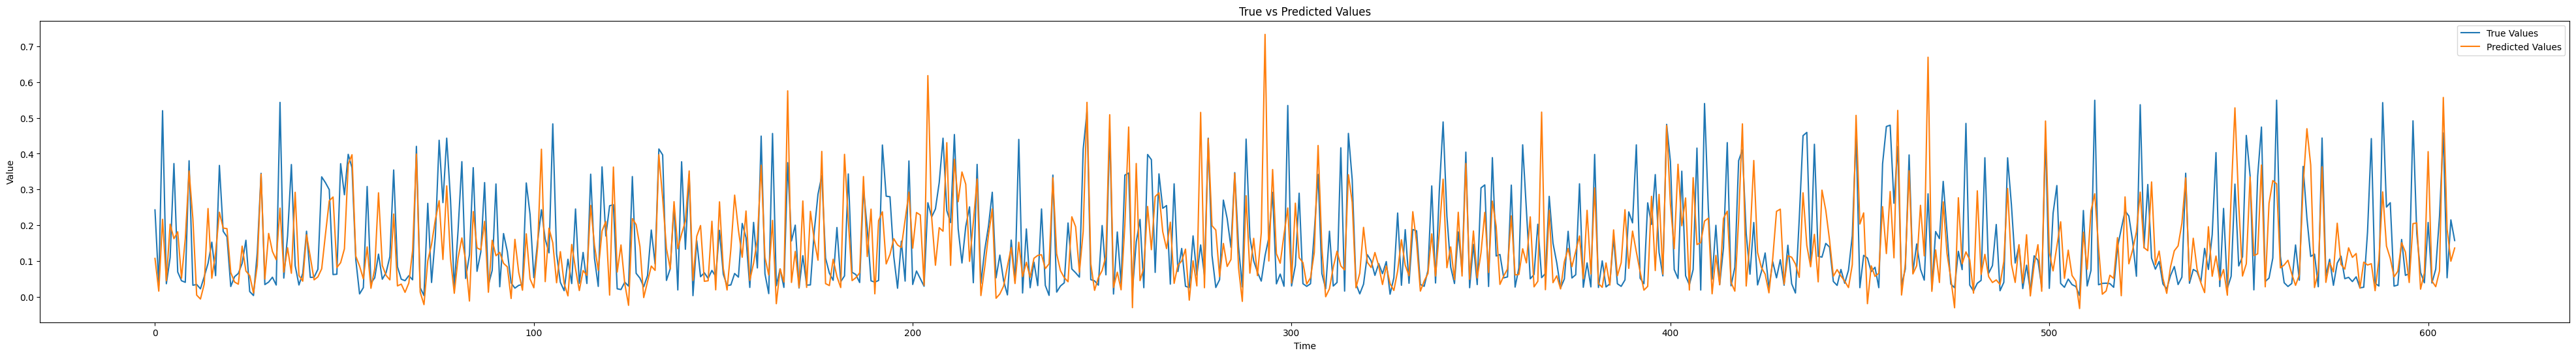

In [ ]:
test_mse, test_mae, test_rmse, test_mape = evaluate_model(FRNet_model, configs, testing_dataloader)

In [ ]:

def evaluate_model(model, config, test_dataloader):
  model.eval()
  test_loss = []
  predictions = []
  true_values = []

  with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_dataloader):
      # Move data to device
      batch_x = batch_x.float().to(config.device)
      batch_y = batch_y.float().to(config.device)

      outputs = model(batch_x)

      # Get prediction part (same logic as training)
      f_dim = -1 if config.features == 'MS' else 0
      outputs = outputs[:, -config.pred_len:, f_dim:]
      batch_y = batch_y[:, -config.pred_len:, f_dim:]

      outputs = torch.mean(outputs, dim=1, keepdim=True)   # (batch, 1, dim)
      batch_y = torch.mean(batch_y, dim=1, keepdim=True)

      pred_batch = outputs.detach().cpu().numpy()
      true_batch = batch_y.detach().cpu().numpy()

      predictions.append(pred_batch)
      true_values.append(true_batch)

  predictions = np.concatenate(predictions, axis=0)  # (num_samples, 1, dim)
  true_values = np.concatenate(true_values, axis=0)  # (num_samples, 1, dim)


  print(f'Predictions shape {predictions.shape}')
  print(f'True values shape {true_values.shape}')

  # Flatten ke 1D
  pred_flat = predictions.reshape(-1)
  true_flat = true_values.reshape(-1)

  return pred_flat, true_flat


predictions, true_values = evaluate_model(FRNet_model, configs, testing_dataloader)

Predictions shape (608, 1, 1)
True values shape (608, 1, 1)


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def evaluate_and_align_with_metrics(model, config, test_loader, test_df):
    model.eval()
    pred_len = config.pred_len
    all_preds = []
    all_indices = []

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            batch_x, batch_y, batch_x_mark, batch_y_mark = batch
            batch_x = batch_x.float().to(config.device)

            # forward
            outputs = model(batch_x)

            # ambil target channel terakhir
            f_dim = -1 if config.features == 'MS' else 0
            outputs = outputs[:, -pred_len:, f_dim:]   # (B, pred_len, 1)

            # ke numpy
            o = outputs.squeeze(-1).detach().cpu().numpy()  # (B, pred_len)
            all_preds.append(o)

            # hitung index horizon
            base_idx = idx * config.batch_size
            for b in range(o.shape[0]):
                start = base_idx + b + config.seq_len
                idxs = np.arange(start, start + pred_len)
                all_indices.append(idxs)

    # gabungkan semua batch
    all_preds = np.concatenate(all_preds, axis=0)   # (N, pred_len)
    all_indices = np.vstack(all_indices)            # (N, pred_len)

    # flatten
    flat_preds = all_preds.flatten()
    flat_idx   = all_indices.flatten()

    # buat DataFrame prediksi
    result_df = pd.DataFrame({
        "index": flat_idx,
        "pred": flat_preds
    })

    # agregasi (jika 1 index diprediksi berkali-kali → ambil rata-rata)
    agg_pred = result_df.groupby("index")["pred"].mean().reset_index()

    # align ke test_df (panjang sama dengan test_df, mulai dari index 0)
    aligned = test_df.reset_index().copy()
    aligned["pred"] = np.nan
    aligned.loc[agg_pred["index"], "pred"] = agg_pred["pred"].values
    aligned["true"] = test_df[config.target].values

    # --- Hitung metrik (hanya pada prediksi valid) ---
    mask = ~aligned["pred"].isna()
    y_true = aligned.loc[mask, "true"].values
    y_pred = aligned.loc[mask, "pred"].values

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAPE: {mape:.4f}")

    metrics = {"MSE": mse, "MAE": mae, "RMSE": rmse, "MAPE": mape}

    return aligned, metrics


aligned, metrics = evaluate_and_align_with_metrics(FRNet_model, configs, testing_dataloader, test_df)

Test MSE: 0.0272
Test MAE: 0.1365
Test RMSE: 0.1649
Test MAPE: 6.0962


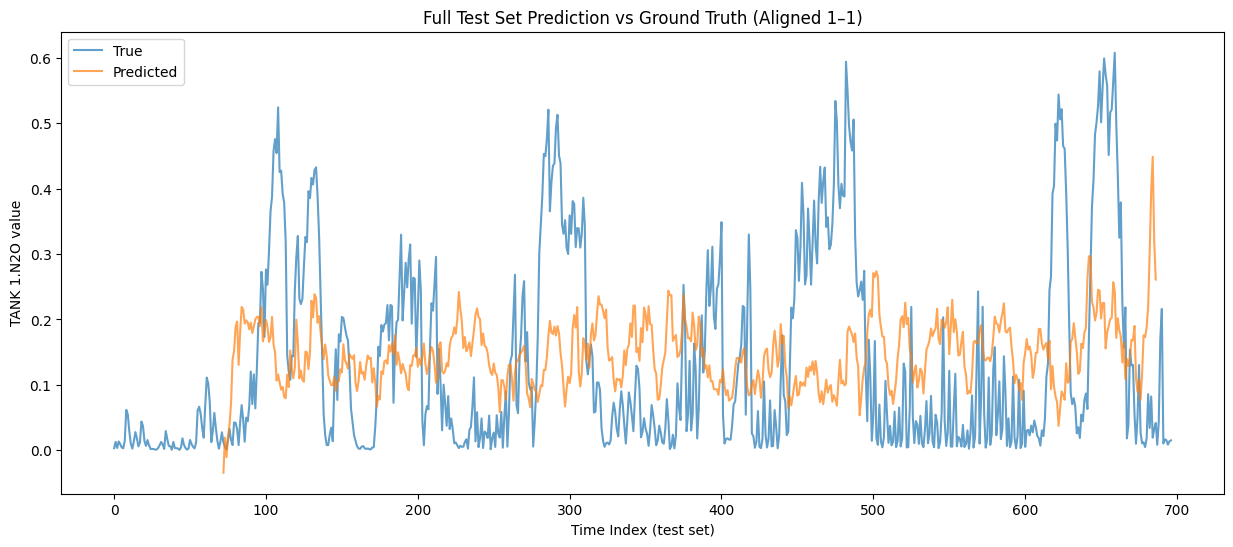

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(aligned["true"].values, label="True", alpha=0.7)
plt.plot(aligned["pred"].values, label="Predicted", alpha=0.7)
plt.xlabel("Time Index (test set)")
plt.ylabel(configs.target)
plt.title("Full Test Set Prediction vs Ground Truth (Aligned 1–1)")
plt.legend()
plt.show()

In [32]:
agg_df

,index,pred
0,72,0.074105
1,73,0.108898
2,74,0.179681
3,75,0.183886
4,76,0.164517
...,...,...
610,682,0.086469
611,683,0.109196
612,684,0.159768
613,685,0.188976


# DEBUG